In [1]:
%load_ext autoreload
%autoreload 2
from src.challenge2 import core
from src import CSV_FILE

import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import root_mean_squared_error

# Introduction

In this notebook, I'll analyse a dataset of diamonds to build a model for price prediction. First, I've done some research on the web to understand the context and detect drawbacks and issues. Also, I've inspected codes from other people to gain insight and to set expectations.

A summary of relevant information: 

* The 4Cs impact on price being carat and cut the most relevant. 
* carat is a unit of weight, so dimensions x, y, and z influence price because weight correlates with size.
* cut is related to the diamond's proportions, symmetry and polish. So ratios such as %depth and %table should be correlated with the cut.
* color and clarity are material properties influencing price less than carat and cut.
* In general, price prediction is a difficult task. The physics features of the diamonds correlate with price and supply/demand forces too. Concepts such as price-per-carat and round-carat values influence prices through shortages and demand.
* carat and price are continuous variables. 
* cut, color and clarity are categorical and ordinal features. So, label encoding and OHE are options.

# Data curation

I'll load the dataset and I'll do basic operations like: 

* Remove rows with missing values (NaN and Null)
* Remove duplicated rows
* Remove rows with non-positive values in price, carat, x, y, z, table_width or z_depth.
* Remove rows where cut, color and clarity have invalid labels.

In [2]:
ds = pd.read_csv(CSV_FILE)
ds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
ds.info() # check if there're null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


In [4]:
ds.isna().sum() # check if there're missing values

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
ds[ds.duplicated()] # check duplicated samples

,carat,cut,color,clarity,depth,table,price,x,y,z
4943,0.31,Premium,E,VS2,61.6,59.0,872,4.35,4.32,2.67


In [6]:
# check if there're non-positive values in strictly positive columns.
ds.query('(price <= 0) or (x <= 0) or (y <=0) or (z <= 0) or (depth * z <= 0) or (table * x <= 0)')

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


I'll check if categorical features have valid data.

In [7]:
ds.cut.isin(core.Model.cut_cat).all()

True

In [8]:
ds.color.isin(core.Model.color_cat).all()

True

In [9]:
ds.clarity.isin(core.Model.clarity_cat).all()

True

In [10]:
# apply curation in place.
core.Model.curation_inplace(ds)
ds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


# Exploratory Data Analysis

On the one hand, I'll analyse which features correlate with price. On the other hand, I'm looking for collinearity between features.

First, I'll compute the correlation matrix of continuous data to check Pearson coefficients.

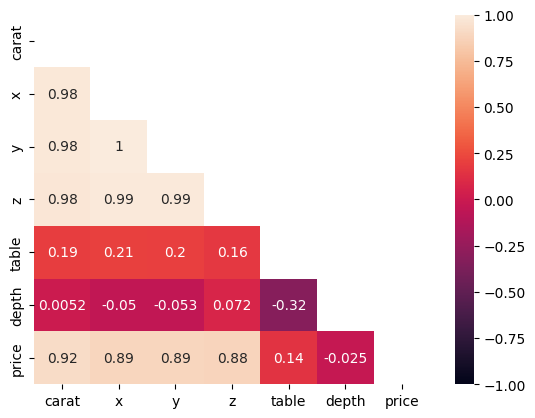

In [11]:
M = ds.get(['carat','x','y','z','table','depth','price']).corr(method='pearson')
sns.heatmap(M, annot=True, vmin=-1, vmax=1, mask = np.triu(np.ones_like(M, dtype=np.bool_)));

Some observations: 
1. carat and price have a strong correlation (.92) as we expected.
2. xyz and price/carat too (.89/.98), it makes sense because weight and size are related.
3. price and %table are weak/moderate correlated (.14).
4. Why  doesn't %depth affect the price? Based on [this](https://www.lumeradiamonds.com/diamond-education/diamond-cut), the correct depth definition is $\%depth=100*z/width$ instead $\%depth=100*z_{depth}/z$. So, I'll transform it.

In [12]:
width = .5*(ds.x+ds.y) # estimation of width.
ds.depth = 100 * ds.z / width;

In [13]:
ds.depth.corr(ds.price)

-0.025667784577717

Again, price and depth seem to be uncorrelated. But we know depth affects price indirectly through the cut feature. So, how is depth represented on the cut feature?

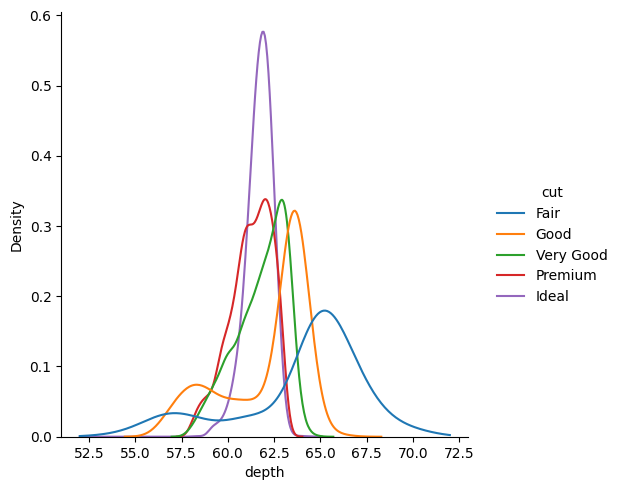

In [14]:
sns.displot(data=ds, x="depth", hue="cut", kind="kde", hue_order=core.Model.cut_cat, clip=(52,72), common_norm=False); 
# common_norm=False helps us avoid misunderstandings due to imbalanced data

In [15]:
ds.cut.value_counts()

cut
Ideal        1987
Premium      1290
Very Good    1097
Good          456
Fair          158
Name: count, dtype: int64

Despite the imbalanced data, the peak values show us cut feature is worse when depth increases (as we expected). When depth decreases, the cut feature is worse too, but instead of finding a peak, we can check which label has more frequency for a given depth (see Round Diamond table [here](https://www.lumeradiamonds.com/diamond-education/round-diamonds)). So, we've observed a depth/cut relationship as the nature of the problem suggests. But, what about the cut/price relationship?

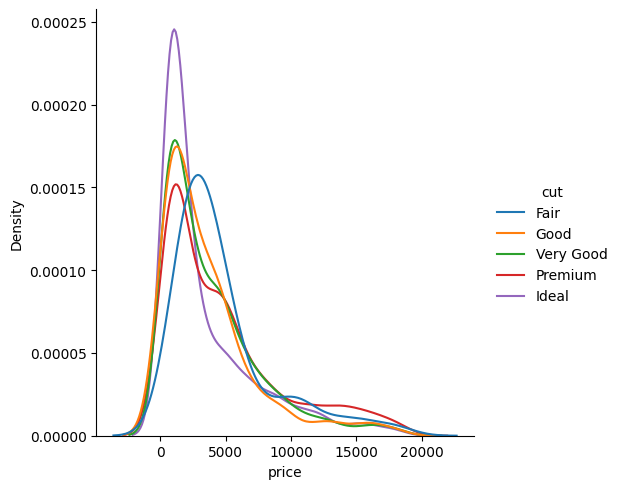

In [16]:
sns.displot(data=ds, x="price", hue="cut", kind="kde", hue_order=core.Model.cut_cat, common_norm=False);

As the plot suggests, the cut feature isn't enough to predict price alone. Despite this plot, we know for research that cut and carat features are very important in price prediction. So, I'll conserve this feature. Now, I'll look carat/price plot

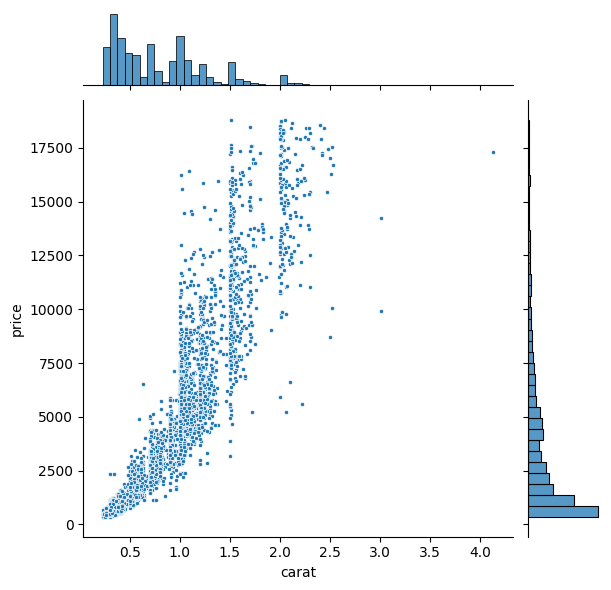

In [17]:
sns.jointplot(data=ds, x='carat', y='price', marker='.');

Some observations:

1. High prices have more dispersion.
2. price-per-carat phenomenon emerges as an exponential effect.
3. carats equal to 1, 1.5, and 2 have big spreads in price. Likely, people buy more diamonds of round-carat.
4. The price histogram is skewed. Cheap diamonds are the most demanded.

Now, I'll inspect how carat correlates price given a cut/clarity/color label.

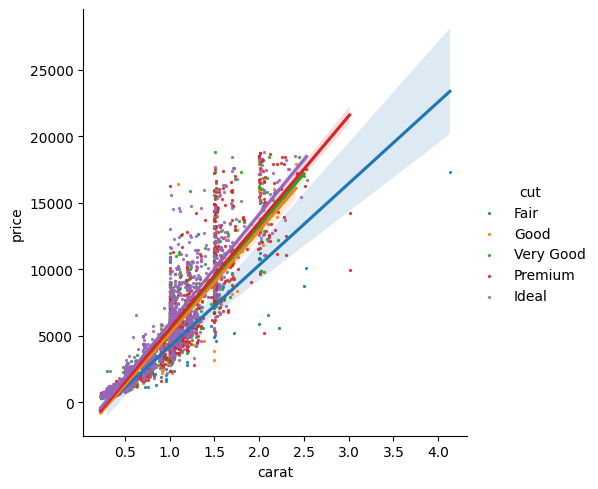

In [18]:
p = sns.lmplot(data=ds, x="carat", y='price', hue='cut', hue_order=core.Model.cut_cat, scatter_kws={'marker':'.', 's':2});

This plot reflects Fair cut has different carat/price relation that other labels. Let's see if the other categories provide more information.

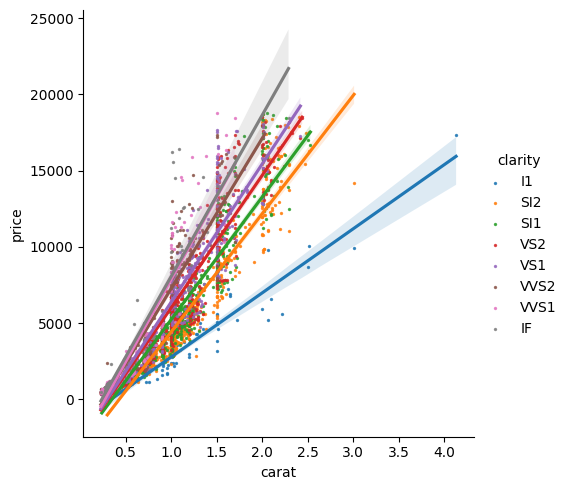

In [19]:
p = sns.lmplot(data=ds, x="carat", y='price', hue='clarity', hue_order=core.Model.clarity_cat, scatter_kws={'marker':'.', 's':2});

clarity behaviour could be interpretated as **low-graded labels are more sensitive to carat than high-graded labels**. So, this feature seems to be important.

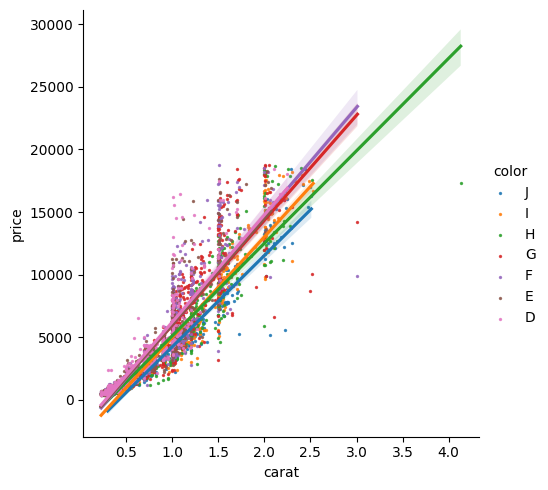

In [20]:
p = sns.lmplot(data=ds, x="carat", y='price', hue='color', hue_order=core.Model.color_cat, scatter_kws={'marker':'.', 's':2});

For color feature, I'm observing a difference in bias instead of sensitivity. So, I'll keept this feature. 

I'll analyse xyz data.

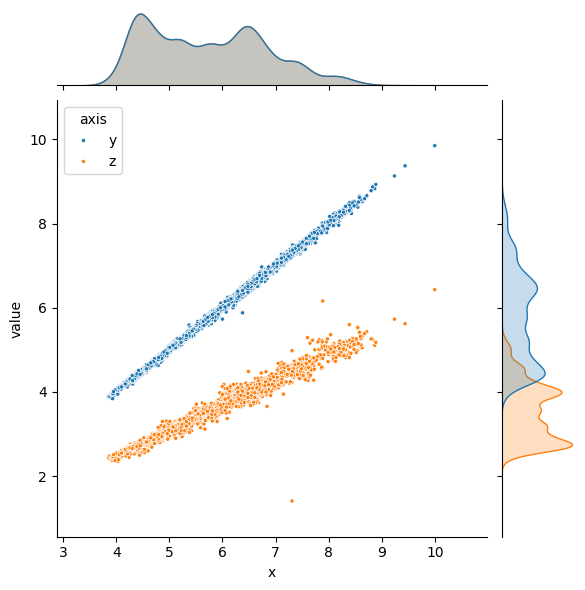

In [21]:
xyz = pd.melt(ds, value_vars=['y', 'z'], var_name='axis')
x2 = pd.Series(np.tile(ds.x, 2), name='x')
sns.jointplot(data=xyz.join(x2), x='x', y='value', hue="axis", marker='.');

Some notes:

1. x and y are nearly equal. It suggests this dataset is imbalanced because most of the diamonds have square or round shapes.
2. x and z have a strong correlation. This is an indication  most of the diamonds have similar depth.
3. x, y and have densities with bimodal shape.


**Final observations about EDA**:

* I won't remove any features. I think if data was more balanced, features like cut or other shapes influencing x and y will provide information.
* Looking in the web, cut, color and clarity could have more labels than in this dataset. That's important if new data will be added.
* I'm not sure about removing outliers. Some high carat values appear in carat/price plot, but those samples are important in I1 class of clarity feature.

# Modeling

I'll perform a k-fold validation to check metrics in five train-test splits with a multiple linear regression model.

In [22]:
# I'll transform price with log function to make it more Gaussian (generally, optimizers require normal distribution on targets)
target = core.Model.extract_target(ds).to_numpy()
log_target = np.log(target)

In [23]:
# We can use ordinal or one hot encoding, I'll use ordinal to keep it simple.
features = core.Model.extract_features(ds)
core.Model.encoding_inplace(features)
features

,carat,cut,color,clarity,depth,table,x,y,z
0,1.10,5,3,2,61.990950,55.0,6.61,6.65,4.11
1,1.29,5,3,3,62.634989,56.0,6.96,6.93,4.35
2,1.20,4,2,3,61.111111,58.0,6.88,6.80,4.18
3,1.50,5,5,3,60.851927,56.0,7.43,7.36,4.50
4,0.90,3,5,4,61.712439,57.0,6.17,6.21,3.82
...,...,...,...,...,...,...,...,...,...
4995,0.38,5,3,6,62.312634,53.3,4.65,4.69,2.91
4996,0.33,4,4,6,61.330327,59.0,4.45,4.42,2.72
4997,1.25,5,1,6,62.124542,56.0,6.81,6.84,4.24
4998,0.31,4,5,4,62.937063,58.0,4.31,4.27,2.70


In [24]:
# standarizing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features) # fit and transform!

In [25]:
# cross validation
model = LinearRegression()
scores = pd.DataFrame(
    cross_validate(
    model,
    scaled_features,
    log_target,
    scoring=('neg_root_mean_squared_error','neg_mean_squared_error'),
    cv=ShuffleSplit(n_splits=5, test_size=0.3, random_state=42),
    return_train_score=True,
    # return_estimator=True
    )
)
scores.rename(columns={
    'test_neg_root_mean_squared_error': 'test_NRMSE',
    'train_neg_root_mean_squared_error': 'train_NRMSE',
    'test_neg_mean_squared_error': 'test_NMSE',
    'train_neg_mean_squared_error': 'train_NMSE'
})

,fit_time,score_time,test_NRMSE,train_NRMSE,test_NMSE,train_NMSE
0,0.003953,0.001048,-0.152991,-0.148550,-0.023406,-0.022067
1,0.001990,0.001043,-0.171314,-0.144245,-0.029349,-0.020807
2,0.001995,0.001043,-0.144018,-0.152215,-0.020741,-0.023169
3,0.000950,0.002046,-0.149500,-0.150080,-0.022350,-0.022524
4,0.000957,0.002000,-0.150100,-0.149631,-0.022530,-0.022389


The optimisation doesn't overfit because the loss (MSE) and RMSE are similar in the train and test data for several folds. If the training metrics were much better than the test metrics, it could be overfitted.

Finally, I'm training a model with overall data.

In [26]:
estimator =  model.fit(scaled_features, log_target)

compute the RMSE metric

In [27]:
pred_target = np.exp(estimator.predict(scaled_features))
root_mean_squared_error(target, pred_target)

937.8593367298457

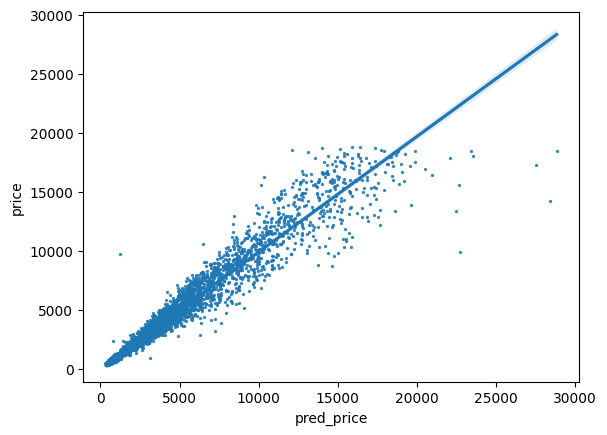

In [28]:
res = pd.DataFrame({'price':target.flatten(), 'pred_price':pred_target.flatten()})
sns.regplot(data=res, x="pred_price", y='price', scatter_kws={'marker':'.', 's':2});

besides RMSE, we observed low prices have lesser dispersion than high prices predictions.